# 1) Install Dependencies

In [1]:
pip -q install ultralytics timm tqdm pillow

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 39.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 40.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 41.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 24.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 12.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 43.1 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


# 2) Import & Setup

In [2]:
# ===============================================================
import os, json, yaml, math, gc, random, shutil, contextlib
from pathlib import Path
from PIL import Image

import torch, torch.nn as nn, torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from tqdm.auto import tqdm
from ultralytics import YOLO
import matplotlib.pyplot as plt
import numpy as np
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

device = "cuda" if torch.cuda.is_available() else "cpu"
torch.manual_seed(42)
print("Device:", device, "| torch", torch.__version__)

def autocast_ctx():
    return torch.autocast(device_type="cuda", enabled=True) if device=="cuda" else contextlib.nullcontext()


Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.
Device: cuda | torch 2.6.0+cu124


# 3) Paths Configuration

In [3]:
# ===============================================================
BASE  = Path("/kaggle/input/assignment-mango/mango")
WORK  = Path("/kaggle/working/mango_ssl_yolov11n_dinov2")
SPLIT = WORK / "yolo_split"
DATA  = WORK / "data_mango.yaml"
SSL_W = WORK / "backbone_ssl_v11n_dinov2.pt"   # SSL weights for YOLOv11n backbone
WORK.mkdir(parents=True, exist_ok=True)


# 4) COCO to YOLO Conversion (Modified for YOLOv11)

In [4]:
import json
import yaml
import shutil
import numpy as np
from pathlib import Path
from collections import defaultdict

def coco2yolo(b, w, h):
    """Convert COCO bbox format to YOLO format"""
    x, y, bw, bh = b
    return (x + bw/2)/w, (y + bh/2)/h, bw/w, bh/h

def convert_mango_dataset():
    """Convert mango COCO dataset to YOLO format with train/val/test splits"""

    # Define the annotation folders and their corresponding image folders
    annotation_folders = {
        'Early-fruit': BASE / "Annotation" / "Early-fruit" / "_annotations.coco.json",
        'Mature': BASE / "Annotation" / "Mature" / "_annotations.coco.json",
        'Ripe': BASE / "Annotation" / "Ripe" / "_annotations.coco.json"
    }

    # Image folders
    image_folders = {
        'Early-Fruit_COCO': BASE / "Early-Fruit_COCO",
        'Mature_COCO': BASE / "Mature_COCO",
        'Premature_COCO': BASE / "Premature_COCO",
        'Ripe_COCO': BASE / "Ripe_COCO"
    }

    # Create output directories
    train_images = SPLIT / "train" / "images"
    train_labels = SPLIT / "train" / "labels"
    val_images = SPLIT / "valid" / "images"
    val_labels = SPLIT / "valid" / "labels"
    test_images = SPLIT / "test" / "images"
    test_labels = SPLIT / "test" / "labels"

    for dir_path in [train_images, train_labels, val_images, val_labels, test_images, test_labels]:
        dir_path.mkdir(parents=True, exist_ok=True)

    all_images = []
    all_annotations = {}
    class_names = set()

    print("➤ Processing annotation files...")

    # Process each annotation file
    for stage, ann_file in annotation_folders.items():
        if ann_file.exists():
            print(f"  • Processing {stage} annotations...")
            try:
                with open(ann_file, 'r') as f:
                    coco_data = json.load(f)

                # Collect class names
                for cat in coco_data['categories']:
                    class_names.add(cat['name'])

                # Create image ID to image info mapping
                id2img = {img['id']: img for img in coco_data['images']}

                # Process annotations
                for ann in coco_data['annotations']:
                    img_id = ann['image_id']
                    if img_id in id2img:
                        img_info = id2img[img_id]
                        img_filename = img_info['file_name']

                        # Convert bbox to YOLO format
                        yolo_bbox = coco2yolo(ann['bbox'], img_info['width'], img_info['height'])

                        # Store annotation
                        if img_filename not in all_annotations:
                            all_annotations[img_filename] = []
                        all_annotations[img_filename].append({
                            'class_id': ann['category_id'] - 1,  # YOLO uses 0-based indexing
                            'bbox': yolo_bbox
                        })

                # Collect image files from this stage
                for img in coco_data['images']:
                    all_images.append({
                        'filename': img['file_name'],
                        'stage': stage,
                        'width': img['width'],
                        'height': img['height']
                    })

            except Exception as e:
                print(f"❌ Error processing {stage}: {e}")
        else:
            print(f"⚠️  Annotation file not found: {ann_file}")

    # Also collect images from folders without annotations (like Premature)
    print("  • Collecting images from image folders...")
    for folder_name, img_folder in image_folders.items():
        if img_folder.exists():
            stage = folder_name.replace('_COCO', '').replace('-', '_')
            for img_file in img_folder.glob('*.jpg'):
                # Check if already processed from annotations
                already_exists = any(img['filename'] == img_file.name for img in all_images)
                if not already_exists:
                    all_images.append({
                        'filename': img_file.name,
                        'stage': stage,
                        'source_folder': img_folder,
                        'width': None,
                        'height': None
                    })

    print(f"  • Found {len(all_images)} total images")
    print(f"  • Found {len(all_annotations)} images with annotations")

    # Create train/val/test split (80/10/10)
    np.random.seed(42)
    np.random.shuffle(all_images)

    n_total = len(all_images)
    n_train = int(0.8 * n_total)
    n_val = int(0.1 * n_total)

    train_imgs = all_images[:n_train]
    val_imgs = all_images[n_train:n_train+n_val]
    test_imgs = all_images[n_train+n_val:]

    print(f"➤ Creating splits:")
    print(f"  • Train: {len(train_imgs)} images")
    print(f"  • Validation: {len(val_imgs)} images")
    print(f"  • Test: {len(test_imgs)} images")

    # Function to copy images and labels for a split
    def copy_split(images, split_name, img_dir, label_dir):
        copied_count = 0
        for img_info in images:
            filename = img_info['filename']
            stage = img_info['stage']

            # Find source image file
            source_img = None
            for folder_name, img_folder in image_folders.items():
                potential_path = img_folder / filename
                if potential_path.exists():
                    source_img = potential_path
                    break

            if source_img and source_img.exists():
                # Copy image
                shutil.copy(source_img, img_dir / filename)

                # Create label file if annotations exist
                if filename in all_annotations:
                    label_filename = f"{Path(filename).stem}.txt"
                    with open(label_dir / label_filename, 'w') as f:
                        for ann in all_annotations[filename]:
                            bbox_str = ' '.join([f"{x:.6f}" for x in ann['bbox']])
                            f.write(f"{ann['class_id']} {bbox_str}\n")

                copied_count += 1
            else:
                print(f"⚠️  Image not found: {filename}")

        print(f"   ✓ Copied {copied_count} images for {split_name}")
        return copied_count

    # Copy files for each split
    copy_split(train_imgs, "train", train_images, train_labels)
    copy_split(val_imgs, "validation", val_images, val_labels)
    copy_split(test_imgs, "test", test_images, test_labels)

    # Create class names list (YOLOv11 compatible)
    class_names_list = sorted(list(class_names)) if class_names else ['mango']

    return class_names_list

# Main conversion logic
if not DATA.exists():
    print("➤ Converting Mango COCO → YOLO …")
    class_names = convert_mango_dataset()

    # Create YAML config for YOLOv11
    config = {
        "path": str(SPLIT),
        "train": "train/images",
        "val": "valid/images",
        "test": "test/images",
        "nc": len(class_names),
        "names": {i: name for i, name in enumerate(class_names)}
    }

    DATA.write_text(yaml.dump(config))
    print("✓ YOLO split ready.")
else:
    print("YOLO split already exists")


➤ Converting Mango COCO → YOLO …
➤ Processing annotation files...
  • Processing Early-fruit annotations...
  • Processing Mature annotations...
  • Processing Ripe annotations...
  • Collecting images from image folders...
  • Found 2004 total images
  • Found 1476 images with annotations
➤ Creating splits:
  • Train: 1603 images
  • Validation: 200 images
  • Test: 201 images
   ✓ Copied 1603 images for train
   ✓ Copied 200 images for validation
   ✓ Copied 201 images for test
✓ YOLO split ready.


# 5) Multi-Mango Dataset for DINO-style SSL (YOLOv11 compatible)

In [5]:
# 5) Multi-Mango Dataset for DINO-style SSL (YOLOv11 compatible)
# ===============================================================
class MultiMangoDino(Dataset):
    SUPP=('*.jpg','*.jpeg','*.png','*.JPG','*.JPEG','*.PNG')
    def __init__(self, roots, g_size=224, l_size=96, n_local=8):
        self.files=[p for r in roots for s in self.SUPP for p in Path(r).rglob(s)]
        if not self.files: raise RuntimeError("No images found for SSL.")
        print(f"Found {len(self.files)} images for SSL training")
        
        self.g1 = transforms.Compose([
            transforms.RandomResizedCrop(g_size, scale=(0.4, 1.0), interpolation=transforms.InterpolationMode.BICUBIC),
            transforms.RandomHorizontalFlip(),
            transforms.ColorJitter(0.1,0.1,0.1,0.1),
            transforms.RandomGrayscale(0.2),
            transforms.GaussianBlur(1, 0.1),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])
        self.g2 = transforms.Compose([
            transforms.RandomResizedCrop(g_size, scale=(0.4, 1.0), interpolation=transforms.InterpolationMode.BICUBIC),
            transforms.RandomHorizontalFlip(),
            transforms.ColorJitter(0.1,0.1,0.1,0.1),
            transforms.RandomGrayscale(0.2),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])
        self.local = transforms.Compose([
            transforms.RandomResizedCrop(l_size, scale=(0.05, 0.4), interpolation=transforms.InterpolationMode.BICUBIC),
            transforms.Resize(g_size, interpolation=transforms.InterpolationMode.BICUBIC),
            transforms.RandomHorizontalFlip(),
            transforms.ColorJitter(0.1,0.1,0.1,0.1),
            transforms.RandomGrayscale(0.2),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])
        self.n_local = n_local
    
    def __len__(self): return len(self.files)
    
    def __getitem__(self, idx):
        try:
            img = Image.open(self.files[idx]).convert("RGB")
            mangos = [self.g1(img), self.g2(img)]  # 2 global crops
            mangos.extend([self.local(img) for _ in range(self.n_local)])  # 8 local crops
            return mangos
        except Exception as e:
            print(f"Error loading image {self.files[idx]}: {e}")
            # Return dummy crops if image loading fails
            dummy = torch.zeros(3, 224, 224)
            return [dummy for _ in range(2 + self.n_local)]


# 6) Build YOLOv11 Nano Model and Extract Backbone

In [6]:
# 6) Build YOLOv11 Nano Model and Extract Backbone
# ===============================================================
print("➤ Loading YOLOv11 Nano model...")
detector = YOLO("yolo11n.yaml")  # YOLOv11 nano architecture
model = detector.model

# Extract backbone (student and teacher)
student_bb = model.model[0].to(device)  # YOLOv11n backbone
teacher_bb = YOLO("yolo11n.yaml").model.model[0].to(device)
teacher_bb.load_state_dict(student_bb.state_dict())
for p in teacher_bb.parameters(): 
    p.requires_grad = False

print("✓ YOLOv11 Nano backbone extracted")

def _pick_last_feat(out):
    """Return a tensor representing the deepest feature map/vector from backbone output."""
    if isinstance(out, (list, tuple)) and len(out) > 0:
        t = out[-1]
    elif isinstance(out, dict) and len(out) > 0:
        t = list(out.values())[-1]
    else:
        t = out
    if not torch.is_tensor(t):
        # some modules could return nested structures
        if isinstance(t, (list, tuple)) and len(t) > 0 and torch.is_tensor(t[-1]):
            t = t[-1]
        elif isinstance(t, dict) and len(t) > 0 and torch.is_tensor(list(t.values())[-1]):
            t = list(t.values())[-1]
        else:
            raise RuntimeError("Backbone output type not understood.")
    return t

class BackboneEncoder(nn.Module):
    """Robust encoder that handles different backbone return types/shapes"""
    def __init__(self, bb): 
        super().__init__()
        self.bb = bb
    
    def forward(self, x):
        out = self.bb(x)
        t = _pick_last_feat(out)
        # Shape adaptation: [B,C,H,W] → GAP; [B,C,T] → mean over T; [B,C] → as-is; else flatten
        if t.ndim == 4:
            z = t.mean(dim=(2,3))  # Global Average Pooling
        elif t.ndim == 3:
            z = t.mean(dim=2)
        elif t.ndim == 2:
            z = t
        else:
            z = t.view(t.size(0), -1)
        return z

student_enc = BackboneEncoder(student_bb).to(device)
teacher_enc = BackboneEncoder(teacher_bb).to(device)

# Test the encoder
with torch.no_grad():
    dummy = torch.zeros(1, 3, 224, 224, device=device)
    feat_dim = student_enc(dummy).shape[1]
print(f"✓ YOLOv11n Backbone feature dimension: {feat_dim}")


➤ Loading YOLOv11 Nano model...
✓ YOLOv11 Nano backbone extracted
✓ YOLOv11n Backbone feature dimension: 16


# 7) DINO-style Projector Heads + Loss Function

In [7]:
# 7) DINO-style Projector Heads + Loss Function
# ===============================================================
OUT_DIM = 256

def projector(in_dim, hid=2048, out=OUT_DIM):
    """DINO-style projector head"""
    return nn.Sequential(
        nn.Linear(in_dim, hid), 
        nn.GELU(), 
        nn.BatchNorm1d(hid),
        nn.Linear(hid, out)
    )

student_head = projector(feat_dim).to(device)
teacher_head = projector(feat_dim).to(device)
teacher_head.load_state_dict(student_head.state_dict())
for p in teacher_head.parameters(): 
    p.requires_grad = False

print("✓ DINO projector heads initialized")

class DINOLoss(nn.Module):
    """DINO-style loss with centering and temperature scheduling"""
    def __init__(self, out_dim, n_global=2,
                 teacher_temp_warm=0.04, teacher_temp=0.07,
                 warmup_frac=0.1, total_epochs=100,
                 center_m=0.9, student_temp=0.1):
        super().__init__()
        self.n_global = n_global
        self.t_warm, self.t_final = teacher_temp_warm, teacher_temp
        self.warmup_frac, self.T = warmup_frac, total_epochs
        self.cm = center_m
        self.student_temp = student_temp
        self.register_buffer("center", torch.zeros(1, out_dim))
    
    def teacher_T(self, epoch):
        """Temperature scheduling for teacher"""
        if epoch < self.warmup_frac * self.T:
            a = epoch / (self.warmup_frac * self.T)
            return self.t_warm + (self.t_final - self.t_warm) * a
        return self.t_final
    
    def forward(self, s_out, t_out, epoch):
        Tt = self.teacher_T(epoch)
        s_logits = [s / self.student_temp for s in s_out]
        t_probs = [F.softmax((t - self.center) / Tt, dim=-1).detach() for t in t_out]
        
        loss = 0
        cnt = 0
        for iq, q in enumerate(t_probs):
            for v, s in enumerate(s_logits):
                if v == iq:  # skip same-index global view
                    continue
                loss += -(q * F.log_softmax(s, dim=-1)).sum(1).mean()
                cnt += 1
        loss /= max(cnt, 1)
        
        # Update center with EMA
        with torch.no_grad():
            batch_center = torch.cat(t_out, 0).mean(0, keepdim=True)
            self.center = self.center * self.cm + (1 - self.cm) * batch_center
        
        return loss

print("✓ DINO loss function initialized")


✓ DINO projector heads initialized
✓ DINO loss function initialized



🔥 DINO-style pretraining on YOLOv11 Nano backbone …
Found 2004 images for SSL training


/tmp/ipykernel_19/3512876067.py:27: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler(enabled=(device=="cuda"))


SSL Ep 1/50:   0%|          | 0/125 [00:00<?, ?it/s]

SSL Epoch 01: loss=5.1951, lr=0.000500


SSL Ep 2/50:   0%|          | 0/125 [00:00<?, ?it/s]

SSL Epoch 02: loss=3.4766, lr=0.000498


SSL Ep 3/50:   0%|          | 0/125 [00:00<?, ?it/s]

SSL Epoch 03: loss=3.1437, lr=0.000496


SSL Ep 4/50:   0%|          | 0/125 [00:00<?, ?it/s]

SSL Epoch 04: loss=2.8747, lr=0.000492


SSL Ep 5/50:   0%|          | 0/125 [00:00<?, ?it/s]

SSL Epoch 05: loss=2.6771, lr=0.000488


SSL Ep 6/50:   0%|          | 0/125 [00:00<?, ?it/s]

SSL Epoch 06: loss=3.4113, lr=0.000482


SSL Ep 7/50:   0%|          | 0/125 [00:00<?, ?it/s]

SSL Epoch 07: loss=4.3074, lr=0.000476


SSL Ep 8/50:   0%|          | 0/125 [00:00<?, ?it/s]

SSL Epoch 08: loss=4.7464, lr=0.000469


SSL Ep 9/50:   0%|          | 0/125 [00:00<?, ?it/s]

SSL Epoch 09: loss=4.3574, lr=0.000461


SSL Ep 10/50:   0%|          | 0/125 [00:00<?, ?it/s]

SSL Epoch 10: loss=4.0572, lr=0.000452


SSL Ep 11/50:   0%|          | 0/125 [00:00<?, ?it/s]

SSL Epoch 11: loss=4.1141, lr=0.000443


SSL Ep 12/50:   0%|          | 0/125 [00:00<?, ?it/s]

SSL Epoch 12: loss=3.8014, lr=0.000432


SSL Ep 13/50:   0%|          | 0/125 [00:00<?, ?it/s]

SSL Epoch 13: loss=3.9324, lr=0.000421


SSL Ep 14/50:   0%|          | 0/125 [00:00<?, ?it/s]

SSL Epoch 14: loss=4.3400, lr=0.000409


SSL Ep 15/50:   0%|          | 0/125 [00:00<?, ?it/s]

SSL Epoch 15: loss=3.8630, lr=0.000397


SSL Ep 16/50:   0%|          | 0/125 [00:00<?, ?it/s]

SSL Epoch 16: loss=3.3408, lr=0.000384


SSL Ep 17/50:   0%|          | 0/125 [00:00<?, ?it/s]

SSL Epoch 17: loss=3.0452, lr=0.000370


SSL Ep 18/50:   0%|          | 0/125 [00:00<?, ?it/s]

SSL Epoch 18: loss=3.2783, lr=0.000356


SSL Ep 19/50:   0%|          | 0/125 [00:00<?, ?it/s]

SSL Epoch 19: loss=3.3291, lr=0.000342


SSL Ep 20/50:   0%|          | 0/125 [00:00<?, ?it/s]

SSL Epoch 20: loss=3.5420, lr=0.000327


SSL Ep 21/50:   0%|          | 0/125 [00:00<?, ?it/s]

SSL Epoch 21: loss=3.8572, lr=0.000312


SSL Ep 22/50:   0%|          | 0/125 [00:00<?, ?it/s]

SSL Epoch 22: loss=3.9353, lr=0.000297


SSL Ep 23/50:   0%|          | 0/125 [00:00<?, ?it/s]

SSL Epoch 23: loss=3.8457, lr=0.000281


SSL Ep 24/50:   0%|          | 0/125 [00:00<?, ?it/s]

SSL Epoch 24: loss=3.5839, lr=0.000266


SSL Ep 25/50:   0%|          | 0/125 [00:00<?, ?it/s]

SSL Epoch 25: loss=3.2822, lr=0.000250


SSL Ep 26/50:   0%|          | 0/125 [00:00<?, ?it/s]

SSL Epoch 26: loss=3.1593, lr=0.000234


SSL Ep 27/50:   0%|          | 0/125 [00:00<?, ?it/s]

SSL Epoch 27: loss=3.1454, lr=0.000219


SSL Ep 28/50:   0%|          | 0/125 [00:00<?, ?it/s]

SSL Epoch 28: loss=3.3039, lr=0.000203


SSL Ep 29/50:   0%|          | 0/125 [00:00<?, ?it/s]

SSL Epoch 29: loss=3.5329, lr=0.000188


SSL Ep 30/50:   0%|          | 0/125 [00:00<?, ?it/s]

SSL Epoch 30: loss=3.6340, lr=0.000173


SSL Ep 31/50:   0%|          | 0/125 [00:00<?, ?it/s]

SSL Epoch 31: loss=3.4634, lr=0.000158


SSL Ep 32/50:   0%|          | 0/125 [00:00<?, ?it/s]

SSL Epoch 32: loss=3.3724, lr=0.000144


SSL Ep 33/50:   0%|          | 0/125 [00:00<?, ?it/s]

SSL Epoch 33: loss=3.2469, lr=0.000130


SSL Ep 34/50:   0%|          | 0/125 [00:00<?, ?it/s]

SSL Epoch 34: loss=3.2029, lr=0.000116


SSL Ep 35/50:   0%|          | 0/125 [00:00<?, ?it/s]

SSL Epoch 35: loss=3.1334, lr=0.000103


SSL Ep 36/50:   0%|          | 0/125 [00:00<?, ?it/s]

SSL Epoch 36: loss=3.1753, lr=0.000091


SSL Ep 37/50:   0%|          | 0/125 [00:00<?, ?it/s]

SSL Epoch 37: loss=3.2188, lr=0.000079


SSL Ep 38/50:   0%|          | 0/125 [00:00<?, ?it/s]

SSL Epoch 38: loss=3.2411, lr=0.000068


SSL Ep 39/50:   0%|          | 0/125 [00:00<?, ?it/s]

SSL Epoch 39: loss=3.3053, lr=0.000057


SSL Ep 40/50:   0%|          | 0/125 [00:00<?, ?it/s]

SSL Epoch 40: loss=3.2894, lr=0.000048


SSL Ep 41/50:   0%|          | 0/125 [00:00<?, ?it/s]

SSL Epoch 41: loss=3.2564, lr=0.000039


SSL Ep 42/50:   0%|          | 0/125 [00:00<?, ?it/s]

SSL Epoch 42: loss=3.2739, lr=0.000031


SSL Ep 43/50:   0%|          | 0/125 [00:00<?, ?it/s]

SSL Epoch 43: loss=3.2645, lr=0.000024


SSL Ep 44/50:   0%|          | 0/125 [00:00<?, ?it/s]

SSL Epoch 44: loss=3.3037, lr=0.000018


SSL Ep 45/50:   0%|          | 0/125 [00:00<?, ?it/s]

SSL Epoch 45: loss=3.2644, lr=0.000012


SSL Ep 46/50:   0%|          | 0/125 [00:00<?, ?it/s]

SSL Epoch 46: loss=3.2727, lr=0.000008


SSL Ep 47/50:   0%|          | 0/125 [00:00<?, ?it/s]

SSL Epoch 47: loss=3.2713, lr=0.000004


SSL Ep 48/50:   0%|          | 0/125 [00:00<?, ?it/s]

SSL Epoch 48: loss=3.2560, lr=0.000002


SSL Ep 49/50:   0%|          | 0/125 [00:00<?, ?it/s]

SSL Epoch 49: loss=3.2769, lr=0.000000


SSL Ep 50/50:   0%|          | 0/125 [00:00<?, ?it/s]

SSL Epoch 50: loss=3.2188, lr=0.000000


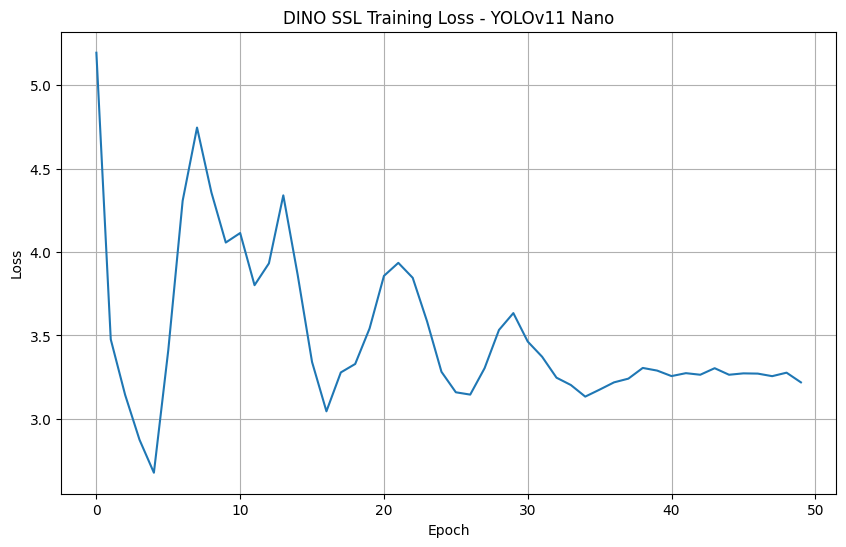

✓ Saved SSL YOLOv11n backbone → /kaggle/working/mango_ssl_yolov11n_dinov2/backbone_ssl_v11n_dinov2.pt


In [8]:
# 8) DINO-style SSL Pretraining on YOLOv11 Nano
# ===============================================================
EPOCHS = 50     # SSL pretraining epochs
BATCH = 16       # Batch size
ACCUM = 2        # Gradient accumulation steps
LR = 5e-4        # Learning rate
WD = 0.05        # Weight decay
EMA0 = 0.990     # EMA momentum base
N_LOCAL = 8      # Number of local crops
NUM_WORKERS = 0  # DataLoader workers

if SSL_W.exists():
    print("✓ SSL backbone cache found – skipping DINO-style pretrain")
else:
    print("\n🔥 DINO-style pretraining on YOLOv11 Nano backbone …")
    
    # Create SSL dataset
    ds = MultiMangoDino([SPLIT/"train/images", SPLIT/"valid/images", SPLIT/"test/images"],
                       g_size=224, l_size=96, n_local=N_LOCAL)
    dl = DataLoader(ds, batch_size=BATCH, shuffle=True, num_workers=NUM_WORKERS,
                    pin_memory=True, drop_last=True)

    # Optimizer and scheduler
    params = list(student_enc.parameters()) + list(student_head.parameters())
    opt = torch.optim.AdamW(params, lr=LR, weight_decay=WD)
    lr_sched = torch.optim.lr_scheduler.CosineAnnealingLR(opt, T_max=EPOCHS)
    scaler = torch.cuda.amp.GradScaler(enabled=(device=="cuda"))

    # Loss function
    loss_fn = DINOLoss(OUT_DIM, n_global=2,
                       teacher_temp_warm=0.04, teacher_temp=0.07,
                       warmup_frac=0.1, total_epochs=EPOCHS,
                       center_m=0.9, student_temp=0.1).to(device)

    steps_per_epoch = len(dl)
    total_steps = steps_per_epoch * EPOCHS
    gstep = 0
    
    # Training loop
    student_enc.train()
    student_head.train()
    
    training_losses = []
    
    for ep in range(EPOCHS):
        ep_loss = 0.0
        accum = 0
        opt.zero_grad(set_to_none=True)
        
        pbar = tqdm(dl, desc=f"SSL Ep {ep+1}/{EPOCHS}", leave=False)
        for mangos in pbar:
            mangos = [v.to(device, non_blocking=True) for v in mangos]  # [g1, g2, l1..lN]
            
            with autocast_ctx():
                # Student processes all crops
                s_feats = [student_enc(v) for v in mangos]
                s_outs = [student_head(z) for z in s_feats]
                
                # Teacher processes only global crops
                with torch.no_grad():
                    t_feats = [teacher_enc(v) for v in mangos[:2]]  # globals only
                    t_outs = [teacher_head(z) for z in t_feats]
                
                loss = loss_fn(s_outs, t_outs, epoch=ep) / ACCUM

            scaler.scale(loss).backward()
            accum += 1
            
            if accum == ACCUM:
                scaler.unscale_(opt)
                nn.utils.clip_grad_norm_(params, 3.0)
                scaler.step(opt)
                scaler.update()
                opt.zero_grad(set_to_none=True)
                accum = 0

                # EMA update (cosine momentum) for teacher backbone + head
                m = 1 - (1 - EMA0) * (math.cos(math.pi * gstep / total_steps) + 1) / 2
                with torch.no_grad():
                    for ps, pt in zip(student_bb.parameters(), teacher_bb.parameters()):
                        pt.data.mul_(m).add_(ps.data, alpha=1-m)
                    for ps, pt in zip(student_head.parameters(), teacher_head.parameters()):
                        pt.data.mul_(m).add_(ps.data, alpha=1-m)
                gstep += 1

            ep_loss += loss.item() * ACCUM
            pbar.set_postfix({'loss': f"{loss.item():.4f}"})

        lr_sched.step()
        avg_loss = ep_loss / steps_per_epoch
        training_losses.append(avg_loss)
        print(f"SSL Epoch {ep+1:02d}: loss={avg_loss:.4f}, lr={opt.param_groups[0]['lr']:.6f}")

    # Save SSL backbone weights
    SSL_W.parent.mkdir(parents=True, exist_ok=True)
    torch.save(student_bb.state_dict(), SSL_W)
    
    # Plot training curve
    plt.figure(figsize=(10, 6))
    plt.plot(training_losses)
    plt.title('DINO SSL Training Loss - YOLOv11 Nano')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.grid(True)
    plt.savefig(WORK / 'ssl_training_curve_yolov11n.png', dpi=150, bbox_inches='tight')
    plt.show()
    
    # Clean up
    del ds, dl
    gc.collect()
    print("✓ Saved SSL YOLOv11n backbone →", SSL_W)


# 9) Object Detection Fine-tuning (YOLOv11 Nano with SSL backbone)

In [9]:
# 9) Object Detection Fine-tuning (YOLOv11 Nano with SSL backbone)
# ===============================================================
print("\n➤ Fine-tuning YOLOv11 Nano detector with SSL backbone...")

# Load fresh YOLOv11 nano model
det = YOLO("yolo11n.yaml")

# Load SSL pretrained weights with error handling
try:
    ssl_weights = torch.load(SSL_W, map_location="cpu")
    missing, unexpected = det.model.model[0].load_state_dict(ssl_weights, strict=False)
    print(f"✓ Loaded SSL backbone: {len(missing)} missing, {len(unexpected)} unexpected keys")
except Exception as e:
    print(f"⚠️ Error loading SSL weights: {e}")
    print("Proceeding with standard initialization")

# Fine-tune the detector
print("🎯 Starting detector fine-tuning...")
results = det.train(
    data=str(DATA),
    epochs=50,
    imgsz=640,
    batch=8,
    project=str(WORK),
    name="ssl_yolov11n_dinov2",
    device=0 if device == "cuda" else "cpu",
    verbose=True,
    patience=10,
    save=True,
    plots=True
)

print("✓ YOLOv11 Nano fine-tuning completed!")



➤ Fine-tuning YOLOv11 Nano detector with SSL backbone...
✓ Loaded SSL backbone: 0 missing, 0 unexpected keys
🎯 Starting detector fine-tuning...
Ultralytics 8.3.189 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=8, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/kaggle/working/mango_ssl_yolov11n_dinov2/data_mango.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=50, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolo11n.yaml, momentum=0.937, mosai

/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


                   all        200        180      0.723      0.778      0.837      0.717
           early-fruit        131        180      0.723      0.778      0.837      0.717
Speed: 0.2ms preprocess, 2.6ms inference, 0.0ms loss, 4.1ms postprocess per image
Results saved to /kaggle/working/mango_ssl_yolov11n_dinov2/ssl_yolov11n_dinov2
✓ YOLOv11 Nano fine-tuning completed!


In [10]:
# 10) Evaluation and Metrics
# ===============================================================
best_pt = WORK / "ssl_yolov11n_dinov2" / "weights" / "best.pt"
if best_pt.exists():
    model_det = YOLO(str(best_pt))
    
    print("➤ Evaluating fine-tuned model...")
    results = model_det.val(
        data=str(DATA),
        imgsz=640,
        batch=4,
        device=0 if device == "cuda" else "cpu",
        verbose=False
    )
    
    # Extract metrics
    try:
        # YOLOv11 metrics extraction
        metrics = results.results_dict
        mp = metrics.get('metrics/precision(B)', 0.0)
        mr = metrics.get('metrics/recall(B)', 0.0)
        map50 = metrics.get('metrics/mAP50(B)', 0.0)
        map5095 = metrics.get('metrics/mAP50-95(B)', 0.0)
    except Exception:
        # Fallback method
        mp = float(results.box.mp) if hasattr(results, 'box') else 0.0
        mr = float(results.box.mr) if hasattr(results, 'box') else 0.0
        map50 = float(results.box.map50) if hasattr(results, 'box') else 0.0
        map5095 = float(results.box.map) if hasattr(results, 'box') else 0.0
    
    print("\n" + "="*50)
    print("FINAL EVALUATION METRICS - YOLOv11 Nano + DINO SSL")
    print("="*50)
    print(f"Precision (mP)    : {mp:.4f}")
    print(f"Recall    (mR)    : {mr:.4f}")
    print(f"F1-Score          : {2*(mp*mr)/(mp+mr) if (mp+mr)>0 else 0:.4f}")
    print(f"mAP@0.50          : {map50:.4f}")
    print(f"mAP@0.50-0.95     : {map5095:.4f}")
    print("="*50)
    
    # Save metrics to file
    metrics_dict = {
        'method': 'DINO',
        'backbone': 'YOLOv11n',
        'precision': float(mp),
        'recall': float(mr),
        'f1_score': float(2*(mp*mr)/(mp+mr) if (mp+mr)>0 else 0),
        'map50': float(map50),
        'map5095': float(map5095)
    }
    
    with open(WORK / 'final_metrics_yolov11n_dino.json', 'w') as f:
        json.dump(metrics_dict, f, indent=2)
    
    print(f"✓ Metrics saved to: {WORK / 'final_metrics_yolov11n_dino.json'}")
else:
    print("⚠️ Best model weights not found!")


➤ Evaluating fine-tuned model...
Ultralytics 8.3.189 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
YOLO11n summary (fused): 100 layers, 2,582,737 parameters, 0 gradients, 6.3 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 679.6±234.5 MB/s, size: 37.6 KB)
val: Scanning /kaggle/working/mango_ssl_yolov11n_dinov2/yolo_split/valid/labels.cache... 131 images, 69 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 200/200 491424.0it/s 0.0s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 50/50 29.6it/s 1.7s


/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


                   all        200        180      0.722      0.778      0.837      0.718
Speed: 0.8ms preprocess, 4.1ms inference, 0.0ms loss, 1.1ms postprocess per image
Results saved to runs/detect/val

FINAL EVALUATION METRICS - YOLOv11 Nano + DINO SSL
Precision (mP)    : 0.7219
Recall    (mR)    : 0.7778
F1-Score          : 0.7488
mAP@0.50          : 0.8374
mAP@0.50-0.95     : 0.7183
✓ Metrics saved to: /kaggle/working/mango_ssl_yolov11n_dinov2/final_metrics_yolov11n_dino.json


# 11) Visualization - Sample Predictions

➤ Visualizing sample predictions...


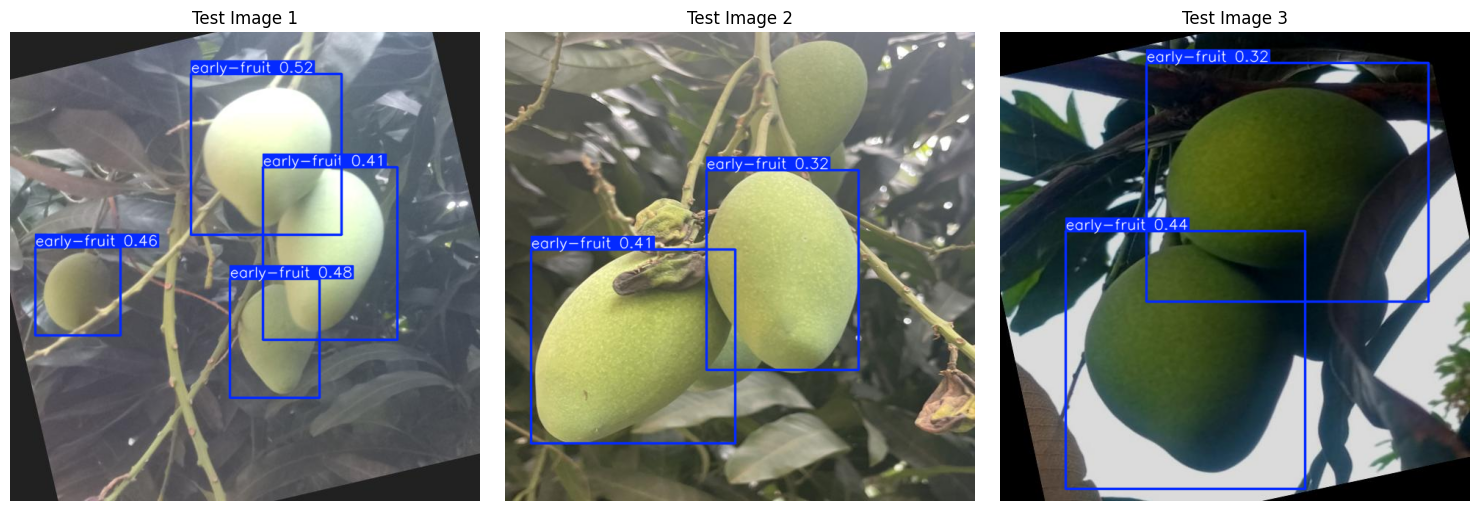

In [11]:
# 11) Visualization - Sample Predictions
# ===============================================================
if best_pt.exists():
    test_imgs = list((SPLIT/"test/images").glob("*.*"))
    if test_imgs:
        print("➤ Visualizing sample predictions...")
        
        # Select random test images
        sample_imgs = random.sample(test_imgs, min(3, len(test_imgs)))
        
        fig, axes = plt.subplots(1, len(sample_imgs), figsize=(15, 5))
        if len(sample_imgs) == 1:
            axes = [axes]
            
        for idx, img_path in enumerate(sample_imgs):
            pred = model_det.predict(
                source=str(img_path),
                imgsz=640,
                conf=0.25,
                device=0 if device == "cuda" else "cpu",
                verbose=False
            )[0]
            
            axes[idx].imshow(pred.plot()[:, :, ::-1])  # BGR->RGB
            axes[idx].set_title(f"Test Image {idx+1}")
            axes[idx].axis("off")
        
        plt.tight_layout()
        plt.savefig(WORK / 'sample_predictions_yolov11n.png', dpi=150, bbox_inches='tight')
        plt.show()
    else:
        print("⚠️ No test images found for visualization.")


# 12) SSL Feature Analysis - PCA Visualization


➤ Analyzing SSL-pretrained YOLOv11n backbone features...
✓ Loaded SSL weights for feature analysis
➤ Extracting features from 1000 images...


Extracting features:   0%|          | 0/1000 [00:00<?, ?it/s]

✓ Feature matrix shape: (1000, 16)
➤ Performing PCA analysis...


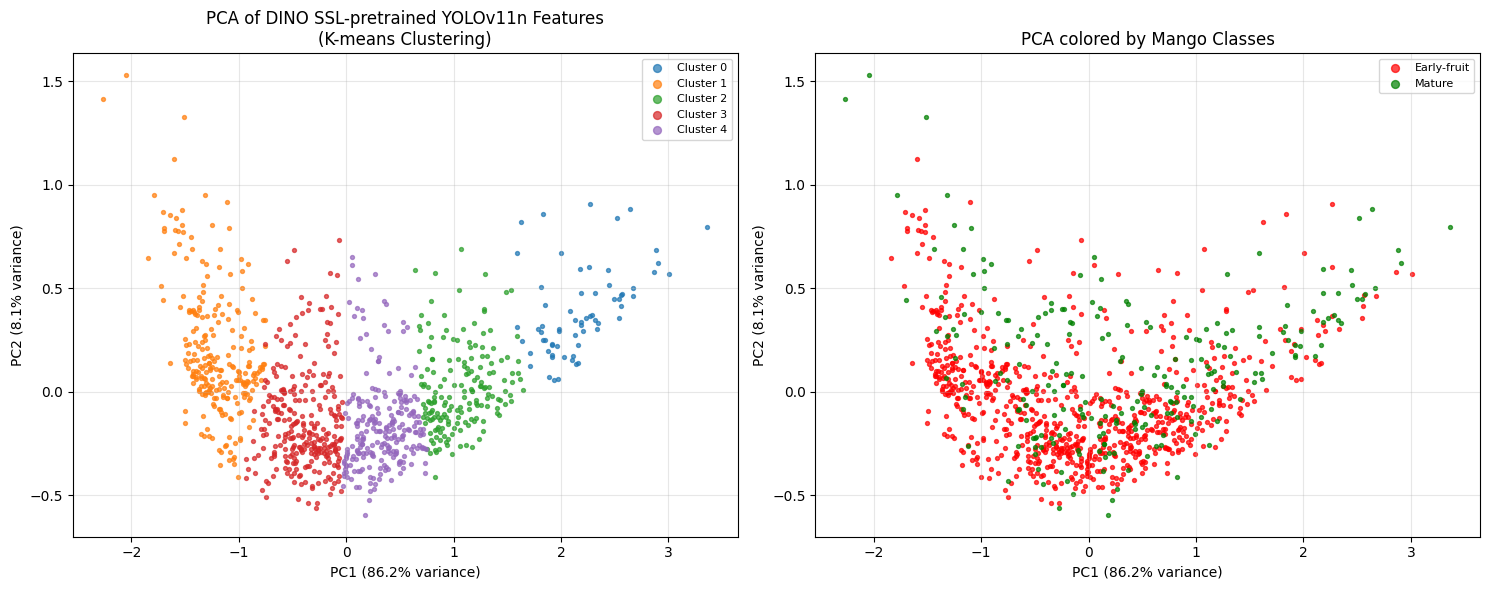

✓ K-means Silhouette Score: 0.3395
✓ Adjusted Rand Index (vs true classes): 0.0000


<_io.TextIOWrapper name='/kaggle/working/mango_ssl_yolov11n_dinov2/final_metrics_yolov11n_dino.json' mode='w' encoding='utf-8'>

In [12]:
# 12) SSL Feature Analysis - PCA Visualization
# ===============================================================
print("\n➤ Analyzing SSL-pretrained YOLOv11n backbone features...")

# Load SSL-pretrained backbone for analysis
det_pca = YOLO("yolo11n.yaml")
if SSL_W.exists():
    det_pca.model.model[0].load_state_dict(torch.load(SSL_W, map_location="cpu"), strict=False)
    print("✓ Loaded SSL weights for feature analysis")
else:
    print("⚠️ Using random initialization for feature analysis")

bb_pca = det_pca.model.model[0].to(device).eval()

class BBEncoder(nn.Module):
    """Backbone encoder for feature extraction"""
    def __init__(self, bb): 
        super().__init__()
        self.bb = bb
    
    def forward(self, x):
        out = self.bb(x)
        t = _pick_last_feat(out)
        if t.ndim == 4:
            z = t.mean(dim=(2,3))  # Global Average Pooling
        elif t.ndim == 3:
            z = t.mean(dim=2)
        elif t.ndim == 2:
            z = t
        else:
            z = t.view(t.size(0), -1)
        return z

enc_pca = BBEncoder(bb_pca).to(device)

# Image preprocessing for PCA
tfm_pca = transforms.Compose([
    transforms.Resize((224, 224)), 
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Collect sample images for PCA analysis
IMG_DIRS = [SPLIT/"train/images", SPLIT/"valid/images"]
files = []
for d in IMG_DIRS:
    if d.exists(): 
        files += list(d.glob("*.*"))

random.shuffle(files)
files = files[:1000] if len(files) > 1000 else files

print(f"➤ Extracting features from {len(files)} images...")

# Extract features
feats = []
labels = []  # For tracking which folder/stage each image comes from
with torch.no_grad():
    for p in tqdm(files, desc="Extracting features"):
        try:
            img = Image.open(p).convert("RGB")
            x = tfm_pca(img).unsqueeze(0).to(device)
            z = enc_pca(x)
            feats.append(z.squeeze(0).cpu().numpy())
            
            # Try to determine image class from filename or path
            img_name = p.name.lower()
            if 'early' in str(p).lower():
                labels.append(0)  # Early-fruit
            elif 'mature' in str(p).lower():
                labels.append(1)  # Mature
            elif 'premature' in str(p).lower():
                labels.append(2)  # Premature
            elif 'ripe' in str(p).lower():
                labels.append(3)  # Ripe
            else:
                labels.append(-1)  # Unknown
        except Exception as e:
            print(f"⚠️ Error processing {p}: {e}")
            continue

feats = np.stack(feats, axis=0)
labels = np.array(labels)
print(f"✓ Feature matrix shape: {feats.shape}")

# PCA Analysis
print("➤ Performing PCA analysis...")
pca = PCA(n_components=2, random_state=42)
xy = pca.fit_transform(feats)

# K-means clustering
k = 5
kmeans_labels = KMeans(n_clusters=k, n_init=10, random_state=42).fit_predict(feats)

# Visualization
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Plot 1: PCA colored by K-means clusters
for i in range(k):
    mask = (kmeans_labels == i)
    ax1.scatter(xy[mask, 0], xy[mask, 1], s=8, alpha=0.7, label=f"Cluster {i}")
ax1.set_title("PCA of DINO SSL-pretrained YOLOv11n Features\n(K-means Clustering)")
ax1.set_xlabel(f"PC1 ({pca.explained_variance_ratio_[0]:.1%} variance)")
ax1.set_ylabel(f"PC2 ({pca.explained_variance_ratio_[1]:.1%} variance)")
ax1.legend(markerscale=2, fontsize=8)
ax1.grid(True, alpha=0.3)

# Plot 2: PCA colored by true classes (if available)
class_names = ['Early-fruit', 'Mature', 'Premature', 'Ripe', 'Unknown']
colors = ['red', 'green', 'blue', 'orange', 'gray']
for i in range(-1, 4):
    mask = (labels == i)
    if np.any(mask):
        ax2.scatter(xy[mask, 0], xy[mask, 1], s=8, alpha=0.7, 
                   color=colors[i+1], label=class_names[i+1])
ax2.set_title("PCA colored by Mango Classes")
ax2.set_xlabel(f"PC1 ({pca.explained_variance_ratio_[0]:.1%} variance)")
ax2.set_ylabel(f"PC2 ({pca.explained_variance_ratio_[1]:.1%} variance)")
ax2.legend(markerscale=2, fontsize=8)
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(WORK / 'pca_analysis_yolov11n_dino.png', dpi=150, bbox_inches='tight')
plt.show()

# Calculate and display clustering quality metrics
from sklearn.metrics import silhouette_score, adjusted_rand_score

# Silhouette score for K-means clustering
sil_score = silhouette_score(feats, kmeans_labels)
print(f"✓ K-means Silhouette Score: {sil_score:.4f}")

# If we have true labels, calculate ARI
if np.sum(labels >= 0) > 10:  # If we have enough labeled samples
    valid_mask = labels >= 0
    ari_score = adjusted_rand_score(labels[valid_mask], kmeans_labels[valid_mask])
    print(f"✓ Adjusted Rand Index (vs true classes): {ari_score:.4f}")
f

# 13) Training Curves Visualization

➤ Visualizing training curves...


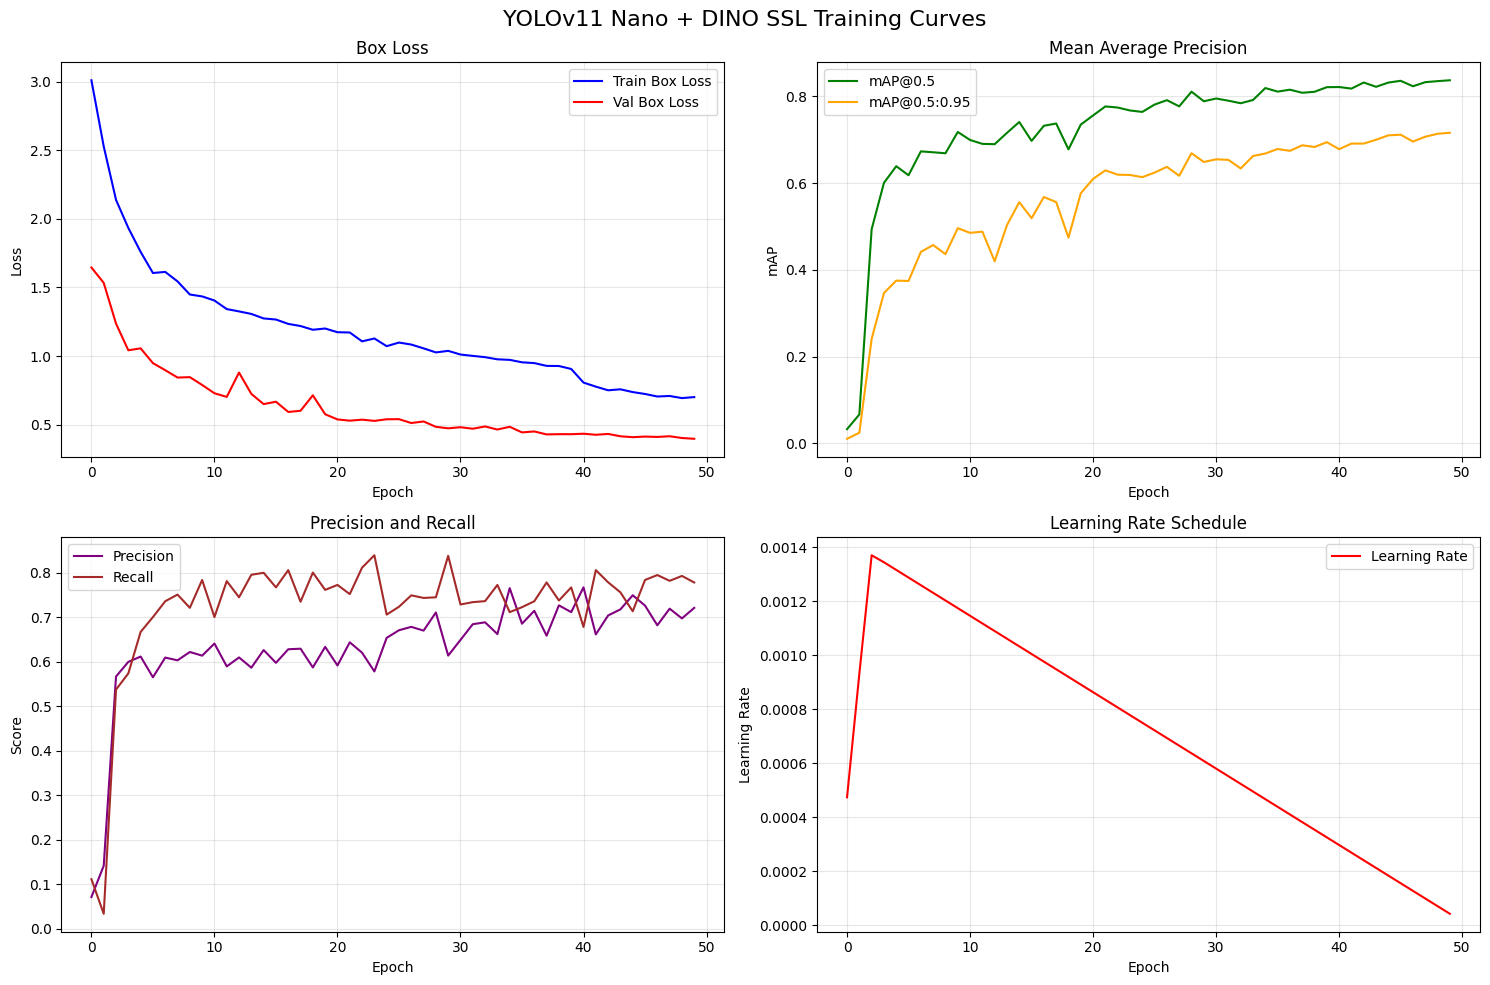

✓ Training curves visualization completed


In [13]:
# ===============================================================
print("➤ Visualizing training curves...")

# Try to load training logs from YOLOv11 training
results_dir = WORK / "ssl_yolov11n_dinov2"
if results_dir.exists():
    # Look for training results
    results_csv = results_dir / "results.csv"
    if results_csv.exists():
        import pandas as pd
        try:
            df = pd.read_csv(results_csv)
            df.columns = df.columns.str.strip()  # Remove whitespace
            
            # Create training curves plot
            fig, axes = plt.subplots(2, 2, figsize=(15, 10))
            
            # Loss curves
            if 'train/box_loss' in df.columns and 'val/box_loss' in df.columns:
                axes[0,0].plot(df['train/box_loss'], label='Train Box Loss', color='blue')
                axes[0,0].plot(df['val/box_loss'], label='Val Box Loss', color='red')
                axes[0,0].set_title('Box Loss')
                axes[0,0].set_xlabel('Epoch')
                axes[0,0].set_ylabel('Loss')
                axes[0,0].legend()
                axes[0,0].grid(True, alpha=0.3)
            
            # mAP curves
            if 'metrics/mAP50(B)' in df.columns and 'metrics/mAP50-95(B)' in df.columns:
                axes[0,1].plot(df['metrics/mAP50(B)'], label='mAP@0.5', color='green')
                axes[0,1].plot(df['metrics/mAP50-95(B)'], label='mAP@0.5:0.95', color='orange')
                axes[0,1].set_title('Mean Average Precision')
                axes[0,1].set_xlabel('Epoch')
                axes[0,1].set_ylabel('mAP')
                axes[0,1].legend()
                axes[0,1].grid(True, alpha=0.3)
            
            # Precision and Recall
            if 'metrics/precision(B)' in df.columns and 'metrics/recall(B)' in df.columns:
                axes[1,0].plot(df['metrics/precision(B)'], label='Precision', color='purple')
                axes[1,0].plot(df['metrics/recall(B)'], label='Recall', color='brown')
                axes[1,0].set_title('Precision and Recall')
                axes[1,0].set_xlabel('Epoch')
                axes[1,0].set_ylabel('Score')
                axes[1,0].legend()
                axes[1,0].grid(True, alpha=0.3)
            
            # Learning rate
            if 'lr/pg0' in df.columns:
                axes[1,1].plot(df['lr/pg0'], label='Learning Rate', color='red')
                axes[1,1].set_title('Learning Rate Schedule')
                axes[1,1].set_xlabel('Epoch')
                axes[1,1].set_ylabel('Learning Rate')
                axes[1,1].legend()
                axes[1,1].grid(True, alpha=0.3)
            
            plt.suptitle('YOLOv11 Nano + DINO SSL Training Curves', fontsize=16)
            plt.tight_layout()
            plt.savefig(WORK / 'training_curves_yolov11n_dino.png', dpi=150, bbox_inches='tight')
            plt.show()
            
            print("✓ Training curves visualization completed")
            
        except Exception as e:
            print(f"⚠️ Error loading training results: {e}")
    else:
        print("⚠️ Training results CSV not found")
else:
    print("⚠️ Results directory not found")


# 14) Summary Report

In [14]:
print("\n" + "="*60)
print("DINO + YOLOv11 NANO TRAINING SUMMARY")
print("="*60)
print(f"SSL Method           : DINO-style Self-Supervised Learning")
print(f"Backbone             : YOLOv11 Nano")
print(f"SSL Epochs           : {EPOCHS}")
print(f"Detection Epochs     : 50")
print(f"SSL Batch Size       : {BATCH}")
print(f"Detection Batch Size : 8")
print(f"Learning Rate        : {LR}")
print(f"Feature Dimension    : {feat_dim}")
print(f"Projection Dimension : {OUT_DIM}")

if SSL_W.exists():
    print(f"SSL Weights Saved    : ✓ {SSL_W}")
else:
    print(f"SSL Weights Saved    : ✗ Not found")

if best_pt.exists():
    print(f"Best Model Saved     : ✓ {best_pt}")
    if 'metrics_dict' in locals():
        print(f"Final mAP@0.5        : {metrics_dict['map50']:.4f}")
        print(f"Final mAP@0.5:0.95   : {metrics_dict['map5095']:.4f}")
        print(f"Final Precision      : {metrics_dict['precision']:.4f}")
        print(f"Final Recall         : {metrics_dict['recall']:.4f}")
        print(f"Final F1-Score       : {metrics_dict['f1_score']:.4f}")
else:
    print(f"Best Model Saved     : ✗ Not found")

print("="*60)


DINO + YOLOv11 NANO TRAINING SUMMARY
SSL Method           : DINO-style Self-Supervised Learning
Backbone             : YOLOv11 Nano
SSL Epochs           : 50
Detection Epochs     : 50
SSL Batch Size       : 16
Detection Batch Size : 8
Learning Rate        : 0.0005
Feature Dimension    : 16
Projection Dimension : 256
SSL Weights Saved    : ✓ /kaggle/working/mango_ssl_yolov11n_dinov2/backbone_ssl_v11n_dinov2.pt
Best Model Saved     : ✓ /kaggle/working/mango_ssl_yolov11n_dinov2/ssl_yolov11n_dinov2/weights/best.pt
Final mAP@0.5        : 0.8374
Final mAP@0.5:0.95   : 0.7183
Final Precision      : 0.7219
Final Recall         : 0.7778
Final F1-Score       : 0.7488


# 15) Cleanup and Final Notes

In [15]:
# ===============================================================
print("\n➤ Cleaning up memory...")
gc.collect()
torch.cuda.empty_cache() if device == "cuda" else None

print("\n✅ DINO + YOLOv11 Nano training completed successfully!")
print(f"\nFiles saved in: {WORK}")
print("📁 Key outputs:")
print(f"  • SSL backbone weights: {SSL_W.name}")
print(f"  • Fine-tuned detector: ssl_yolov11n_dinov2/weights/best.pt")
print(f"  • Training curves: ssl_training_curve_yolov11n.png")
print(f"  • PCA analysis: pca_analysis_yolov11n_dino.png")
print(f"  • Final metrics: final_metrics_yolov11n_dino.json")

print("\n🎯 Next steps:")
print("  1. Compare results with other SSL methods (BYOL)")
print("  2. Compare with other backbones (YOLOv10, YOLOv12)")
print("  3. Analyze ablation study results")
print("  4. Create comprehensive report")

print("\n" + "="*60)
print("END OF DINO + YOLOv11 NANO IMPLEMENTATION")
print("="*60)


➤ Cleaning up memory...

✅ DINO + YOLOv11 Nano training completed successfully!

Files saved in: /kaggle/working/mango_ssl_yolov11n_dinov2
📁 Key outputs:
  • SSL backbone weights: backbone_ssl_v11n_dinov2.pt
  • Fine-tuned detector: ssl_yolov11n_dinov2/weights/best.pt
  • Training curves: ssl_training_curve_yolov11n.png
  • PCA analysis: pca_analysis_yolov11n_dino.png
  • Final metrics: final_metrics_yolov11n_dino.json

🎯 Next steps:
  1. Compare results with other SSL methods (BYOL)
  2. Compare with other backbones (YOLOv10, YOLOv12)
  3. Analyze ablation study results
  4. Create comprehensive report

END OF DINO + YOLOv11 NANO IMPLEMENTATION
